# Code for reproducing analysis and figure in paper

The notebook is intended for reproducing major analysis and figure in [Wang et al. (2024)](https://www.biorxiv.org/content/10.1101/2023.10.12.562107v2). To ensure proper code execution, you will need helper functions from the analysis_helper.py and figure_helper.py from the [reproduction folder](https://github.com/neonine2/morpheus-spatial/tree/19092c7ca67959a9a80fc724f12ccb9d87fc7ce1/reproduction).

**IMPORTANT:** Note all code in this folder is only meant to be used for reproducing analysis in the paper, not for analyzing your own output as there are hard-coded parameters that only makes sense for specific datasets

## Install required packages and download output files

First, we need to install several core packages and download output files on top of which we will run our analysis. The notebook is set up to perform analysis on all data sets used in the original publication. You will need to be careful which with code block to run if you are only interested in running analysis on a specific data set output

In [ ]:
!pip install morpheus-spatial umap-learn mplscience statsmodels -Uqqqq

import morpheus as mp
import mplscience #optional: set the default style for matplotlib
mplscience.available_styles()
mplscience.set_style(reset_current=True)

## Load data sets

In [2]:
# initialize a SpatialDataset Object (modify the path to the data on your machine)
BASE_DIR = "melanoma_output"
mla_data = mp.SpatialDataset(
    input_path=f"{BASE_DIR}/singlecell.csv",  # path to the single cell data
    cf_dir=f"{BASE_DIR}/cf/run_0",  # path to the computed perturbations
    model_path=f"{BASE_DIR}/model/unet.ckpt",  # path to the trained model
    additional_cols=["Cancer_Stage"],
)

BASE_DIR = "crc_output"
crc_data = mp.SpatialDataset(
    input_path=f"{BASE_DIR}/singlecell.csv",
    cf_dir=f"{BASE_DIR}/cf/run_0",
    model_path=f"{BASE_DIR}/model/unet.ckpt",
    additional_cols=["type", "FLD"],
)

BASE_DIR = "breast_output"
bst_data = mp.SpatialDataset(
    input_path=f"{BASE_DIR}/singlecell.csv",
)

## 0. Assess model performance (all data set required)

In [5]:
from analysis_helper import get_rmse_and_prediction, optimize_threshold
from figure_helper import plot_prediction_scatterplot, plot_rmse

Melanoma RMSE: 0.08574384616148611
CRC RMSE: 0.0769245070150388
Number of tissues filtered out: 1
Number of tissues: 106
Number of tissues filtered out: 4
Number of tissues: 126
Breast tumor RMSE: 0.1085571207977729


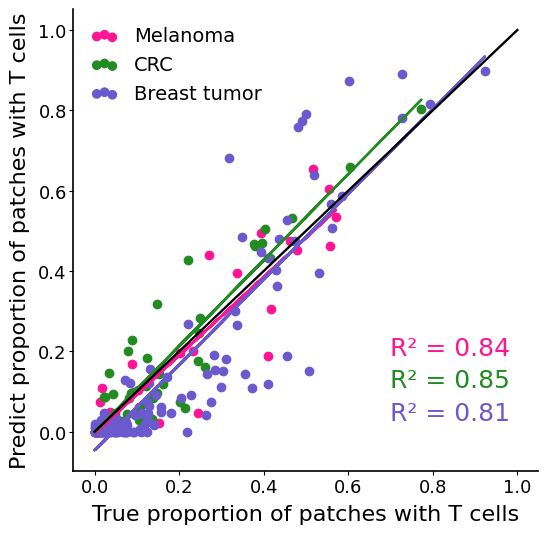

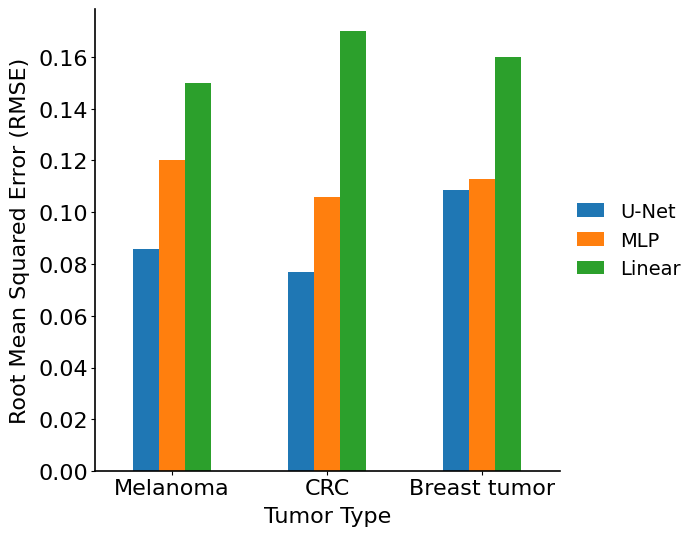

In [6]:
all_pred = {}
all_rmse = {}
thresholds = {}
for name, data in {
    "Melanoma": mla_data,
    "CRC": crc_data,
    "Breast tumor": bst_data,
}.items():
    thresh = optimize_threshold(data, split="validate")
    pred, rmse = get_rmse_and_prediction(data, split="test", classify_threshold=thresh)
    print(f"{name} RMSE: {rmse}")
    all_pred[name] = pred
    all_rmse[name] = rmse
    thresholds[name] = thresh

plot_prediction_scatterplot(all_pred)
plot_rmse(all_rmse)

## 1. Visualizing patient-level perturbations

In [3]:
# import relevant functions
from analysis_helper import retrieve_perturbation
from figure_helper import plot_patient_perturbation

### Melanoma

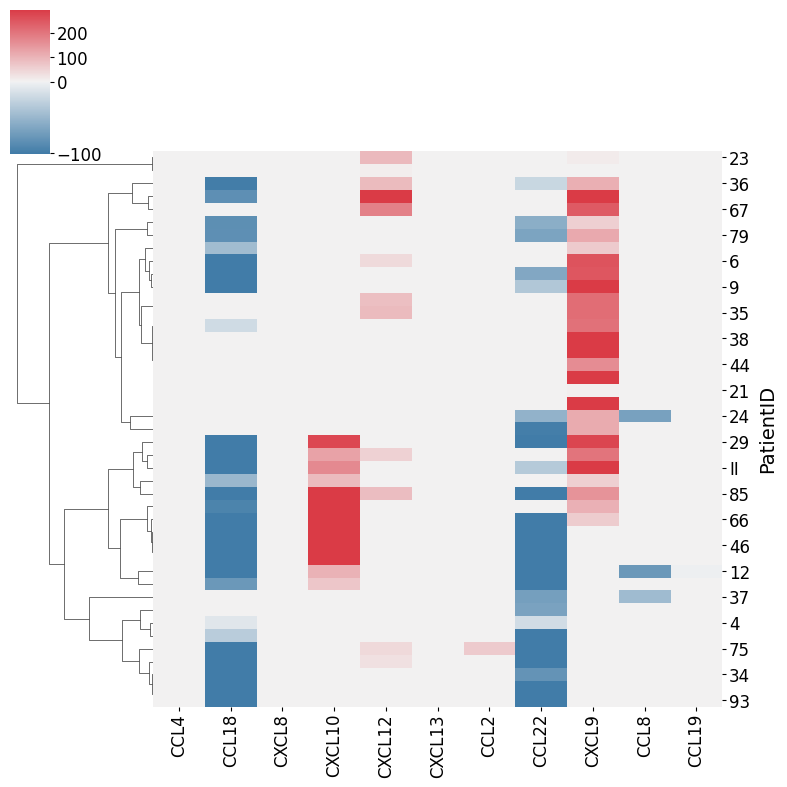

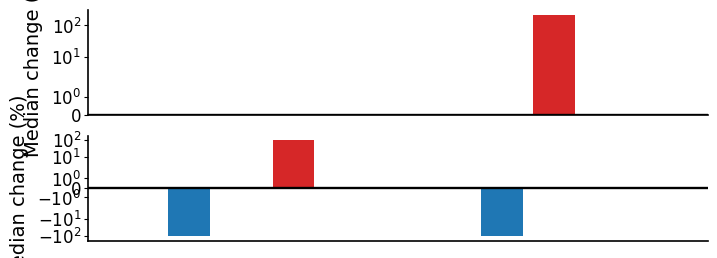

cluster  Cancer_Stage
1        IV              11
         III              7
         III or IV        1
         unknown          1
2        IV              11
         III              9
         unknown          1
Name: count, dtype: int64


,CCL4_mRNA,CCL18_mRNA,CXCL8_mRNA,CXCL10_mRNA,CXCL12_mRNA,CXCL13_mRNA,CCL2_mRNA,CCL22_mRNA,CXCL9_mRNA,CCL8_mRNA,CCL19_mRNA
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,214.568165,0.0,0.0
1,0.0,-100.000015,0.0,88.148949,0.0,0.0,0.0,-100.0,0.000000,0.0,0.0


In [7]:
cf_mla, channel_to_perturb_mla = retrieve_perturbation(
    mla_data, additional_col=["Cancer_Stage"]
)
strategy_mla, patient_cf_mla = plot_patient_perturbation(
    mla_data,
    cf_mla,
    channel_to_perturb_mla,
    numClust=3,
    extra_cols=["Cancer_Stage"],
    keep_top_2=True,
)
display(strategy_mla)

### CRC

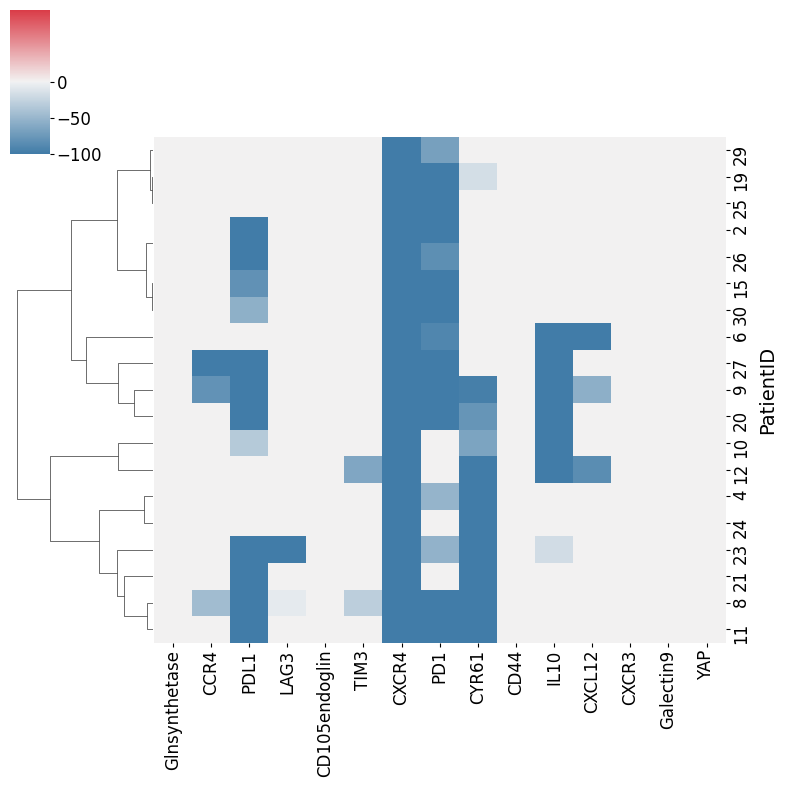

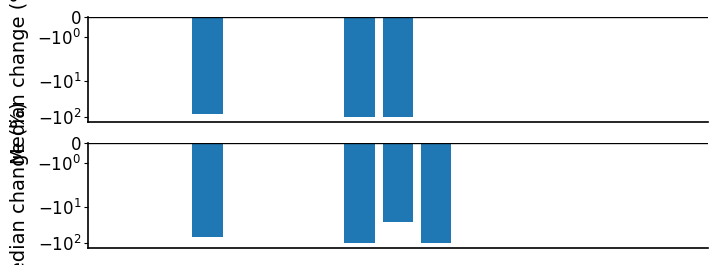

cluster  FLD
1        1.0    4
         0.0    3
         2.0    2
         3.0    2
2        0.0    7
         3.0    1
Name: count, dtype: int64


,Glnsynthetase,CCR4,PDL1,LAG3,CD105endoglin,TIM3,CXCR4,PD1,CYR61,CD44,IL10,CXCL12,CXCR3,Galectin9,YAP
0,0.0,0.0,-81.967278,0.0,0.0,0.0,-100.0,-100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,-67.016325,0.0,0.0,0.0,-100.0,-25.793957,-100.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
cf_crc, channel_to_perturb_crc = retrieve_perturbation(
    crc_data, additional_col=["type", "FLD"]
)
strategy_crc, patient_cf_crc = plot_patient_perturbation(
    crc_data,
    cf_crc,
    channel_to_perturb_crc,
    numClust=2,
    extra_cols=["FLD"],
)
display(strategy_crc)

## 2. Assess effectiveness of perturbation on test cohort

In [ ]:
# import relevant functions
from analysis_helper import assess_perturbation
from figure_helper import plot_perturbation_performance

### Melanoma

In [ ]:
tcell_level_melanoma = assess_perturbation(
    mla_data,
    strategy_mla,
    data_split="test",
    classify_threshold=thresholds["Melanoma"],
    additional_col=["Cancer_Stage"],
)

plot_perturbation_performance(
    tcell_level_melanoma,
)

### CRC

In [ ]:
tcell_level_crc = assess_perturbation(
    crc_data,
    strategy_crc,
    data_split="test",
    classify_threshold=thresholds["CRC"],
    additional_col=["FLD", "type"],
)

tcell_level_crc["FLD"] = tcell_level_crc.apply(
    lambda x: 1 if x["FLD"] > 0 else 0, axis=1
)

plot_perturbation_performance(
    tcell_level_crc,
    patient_phenotype="FLD",
    strategy_mapping={"strategy_1": 1, "strategy_2": 0},
)

## 3. Visualizing perturbation vectors in UMAP space

In [ ]:
from analysis_helper import get_umap_embeddings
from figure_helper import plot_umap_embedding, plot_umap_embedding_crc

### Melanoma

In [ ]:
embedding_mla, umap_cf_mla = get_umap_embeddings(
    mla_data, cf_mla, channel_to_perturb_mla
)
plot_umap_embedding(embedding_mla, umap_cf_mla, pie_chart=True)

### CRC

In [ ]:
embedding_crc, umap_cf_crc = get_umap_embeddings(
    crc_data, cf_crc, channel_to_perturb_crc, additional_col=["type"]
)
plot_umap_embedding_crc(embedding_crc, umap_cf_crc)

## 4. Comparing patients across clusters with volcano plots

In [ ]:
from analysis_helper import differential_analysis_celltype, differential_analysis_genes
from figure_helper import make_volcano_plot

### Melanoma

In [ ]:
mla_celltype_da = differential_analysis_celltype(mla_data, patient_cf_mla)
mla_genes_da = differential_analysis_genes(
    mla_data, patient_cf_mla, channel_to_perturb_mla
)
make_volcano_plot(mla_genes_da, mla_celltype_da)

### CRC

In [ ]:
crc_celltype_da = differential_analysis_celltype(crc_data, patient_cf_crc)
crc_genes_da = differential_analysis_genes(
    crc_data, patient_cf_crc, channel_to_perturb_crc
)
make_volcano_plot(crc_genes_da, crc_celltype_da)

## 5. Tissue-level perturbation heatmap (CRC only)

In [ ]:
from figure_helper import plot_tissue_level_perturbation

In [ ]:
plot_tissue_level_perturbation(cf_crc, channel_to_perturb_crc)

## 6. Patch-level perturbation heatmap (Melanoma only)

In [ ]:
from analysis_helper import get_IHC_subset
from figure_helper import make_patch_heatmap_mla

In [ ]:
X, label = get_IHC_subset(mla_data, channel_to_perturb_mla)
make_patch_heatmap_mla(X, label)

## 7. Strategy of varying sparsity

In [ ]:
from analysis_helper import assess_perturbation
from figure_helper import make_multi_strat_plot
import pandas as pd

### CRC

In [ ]:
allStrategy = pd.read_csv("allstrat_crc.csv")
tcell_crc = assess_perturbation(
    crc_data,
    allStrategy,
    data_split="test",
    classify_threshold=thresholds['CRC'],
    additional_col=["FLD", "type"],
)
infiltrate_lower, infiltrate_upper = make_multi_strat_plot(
    allStrategy,
    tcell_crc,
    chemlabel=["CXCR4", "PD1", "CYR61", "PDL1", "IL10"]
)

### Melanoma

In [ ]:
allStrategy = pd.read_csv("allstrat_mla.csv")
tcell_mla = assess_perturbation(
    mla_data,
    allStrategy,
    data_split="test",
    classify_threshold=thresholds['Melanoma'],
)
infiltrate_lower, infiltrate_upper = make_multi_strat_plot(
    allStrategy,
    tcell_mla,
    chemlabel=["CXCL9", "CCL18", "CCL22", "CXCL10", "CXCL12", "CXCL8"]
)

## 8. Correlation plots

In [ ]:
from analysis_helper import get_feature_correlation
from figure_helper import plot_correlation

### Melanoma

In [ ]:
corr_mla = get_feature_correlation(mla_data, channel_to_perturb_mla)
plot_correlation(corr_mla)

### CRC

In [ ]:
corr_crc = get_feature_correlation(crc_data, channel_to_perturb_crc)
plot_correlation(corr_crc)

## 9. T cell map

In [ ]:
from figure_helper import get_example_Tcell_map, make_multiple_Tcell_map

In [ ]:
# single tissue slice
get_example_Tcell_map(mla_data, tcell_level_melanoma, img=23)

# all (large) test cohort tissue slice
make_multiple_Tcell_map(mla_data, thresholds['Melanoma'])

In [ ]:
make_multiple_Tcell_map(crc_data, thresholds['CRC'])

In [ ]:
make_multiple_Tcell_map(bst_data, thresholds['Breast tumor'])